In [1]:
"""
Created on Wed Jan 10 17:13:16 2024
@author: Wu Yuxuan
"""

import os
import warnings

from gseapy import Msigdb
import decoupler as dc
import gseapy as gp
from gseapy import barplot, dotplot
import scFates as scf
import ktplotspy as kpy
from plotnine import save_as_pdf_pages
import pandas as pd
import anndata as ad
import scanpy as sc
import seaborn as sns
import numpy as np
from matplotlib import rc_context
from adjustText import adjust_text
from matplotlib import pyplot as plt
from ridgeplot import ridgeplot

import cellrank as cr
# import scanpy as sc
import scvelo as scv

from cellphonedb.src.core.methods import cpdb_statistical_analysis_method

from statannotations.Annotator import Annotator

In [2]:
seed = 1
warnings.simplefilter(action='ignore', category=FutureWarning)
# info
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(vector_friendly=True, dpi_save=1200) 
sc.logging.print_header()

scanpy==0.1.dev3254+g5b9bc72 anndata==0.10.3 umap==0.5.5 numpy==1.26.0 scipy==1.11.3 pandas==1.5.2 scikit-learn==1.1.3 statsmodels==0.14.0 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.11


In [3]:
os.chdir('/home/wu/datb1/reseq_ppp/Pub_PPP_code')

In [4]:
sns.set_style("white")

### Data Preparation

In [5]:
adata_ker = ad.read_h5ad('/home/wu/datb1/reseq_ppp/processed_data/KC_PPP_10X.h5ad').raw.to_adata()
adata_immu = ad.read_h5ad('/home/wu/datb1/reseq_ppp/processed_data/IMMU_PPP_10X.h5ad').raw.to_adata()
adata_dermis = ad.read_h5ad('/home/wu/datb1/reseq_ppp/processed_data/DERMIS_PPP_10X.h5ad').raw.to_adata()

adata_ker.obs['leiden_original'] = adata_ker.obs['leiden'].astype('category').copy()
adata_immu.obs['leiden_original'] = adata_immu.obs['leiden'].astype('category')
adata_dermis.obs['leiden_original'] = adata_dermis.obs['leiden'].astype('category')

# only keep basal and suprabasal cells
adata_ker = adata_ker[adata_ker.obs.leiden_original.str.contains('Suprabasal|Basal'), :].copy()
adata_ker.obs['leiden'] = adata_ker.obs['leiden_original'].astype(str).str.split().str[0] + '_' + adata_ker.obs['Meta'].astype(str) + '_KC'

In [6]:
adata_bulk_ker_immu = adata_ker.concatenate(adata_immu, batch_key='sample_type', batch_categories=['KC', 'IMMU'])
adata_bulk_ker_immu.obs.leiden[adata_bulk_ker_immu.obs.sample_type == 'IMMU'] = 'Immu'
adata_bulk_ker_immu.write('/home/wu/datb1/reseq_ppp/interaction_data/KC_IMMU_normalised_log_counts.h5ad')

del adata_bulk_ker_immu

In [7]:
# merge two datasets
adata_ker.obs['leiden'] = adata_ker.obs['leiden_original'].astype(str).str.split().str[0] + '_' + adata_ker.obs['Meta'].astype(str) + '_KC'
adata_merge = adata_ker.concatenate(adata_immu, adata_dermis, batch_key='sample_type', batch_categories=['KC', 'IMMU', 'DERMIS'])

metadata_df = adata_merge.obs.reset_index().loc[:, ['index', 'leiden']]
metadata_df.columns = ['barcode_sample', 'cell_type']
metadata_df.to_csv('/home/wu/datb1/reseq_ppp/interaction_data/metadata.tsv', sep='\t', index=False)

In [8]:
adata_merge.write('/home/wu/datb1/reseq_ppp/interaction_data/merged_normalised_log_counts.h5ad')

### Interaction analysis

In [9]:
from IPython.display import HTML, display
from cellphonedb.utils import db_releases_utils

display(HTML(db_releases_utils.get_remote_database_versions_html()['db_releases_html_table']))

In [10]:
# -- Version of the databse
cpdb_version = 'v5.0.0'

# -- Path where the input files to generate the database are located
cpdb_target_dir = os.path.join('/home/wu/datb1/reseq_ppp/', cpdb_version)

In [11]:
cpdb_file_path = '/home/wu/datb1/reseq_ppp/v5.0.0/cellphonedb.zip'
meta_file_path = '/home/wu/datb1/reseq_ppp/interaction_data/metadata.tsv'
counts_file_path = '/home/wu/datb1/reseq_ppp/interaction_data/merged_normalised_log_counts.h5ad'
out_path = '/home/wu/datb1/reseq_ppp/interaction_results/method2_withScore'

In [12]:
cpdb_results = cpdb_statistical_analysis_method.call(
    cpdb_file_path = cpdb_file_path,                 # mandatory: CellphoneDB database zip file.
    meta_file_path = meta_file_path,                 # mandatory: tsv file defining barcodes to cell label.
    counts_file_path = counts_file_path,             # mandatory: normalized count matrix - a path to the counts file, or an in-memory AnnData object
    counts_data = 'hgnc_symbol',                     # defines the gene annotation in counts matrix.
    # active_tfs_file_path = active_tf_path,           # optional: defines cell types and their active TFs.
    # microenvs_file_path = microenvs_file_path,       # optional (default: None): defines cells per microenvironment.
    score_interactions = True,                       # optional: whether to score interactions or not. 
    iterations = 100000,                               # denotes the number of shufflings performed in the analysis.
    threshold = 0.05,                                 # defines the min % of cells expressing a gene for this to be employed in the analysis.
    threads = 12,                                     # number of threads to use in the analysis.
    debug_seed = 1,                                 # debug randome seed. To disable >=0.
    result_precision = 5,                            # Sets the rounding for the mean values in significan_means.
    pvalue = 0.05,                                   # P-value threshold to employ for significance.
    subsampling = False,                             # To enable subsampling the data (geometri sketching).
    subsampling_log = False,                         # (mandatory) enable subsampling log1p for non log-transformed data inputs.
    subsampling_num_pc = 100,                        # Number of componets to subsample via geometric skectching (dafault: 100).
    # subsampling_num_cells = 1000,                    # Number of cells to subsample (integer) (default: 1/3 of the dataset).
    separator = '|',                                 # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
    debug = False,                                   # Saves all intermediate tables employed during the analysis in pkl format.
    output_path = out_path,                          # Path to save results.
    output_suffix = None                             # Replaces the timestamp in the output files by a user defined string in the  (default: None).
    )

Reading user files...
The following user files were loaded successfully:
/home/wu/datb1/reseq_ppp/interaction_data/merged_normalised_log_counts.h5ad
/home/wu/datb1/reseq_ppp/interaction_data/metadata.tsv
[ ][CORE][26/05/24-16:07:37][INFO] [Cluster Statistical Analysis] Threshold:0.05 Iterations:100000 Debug-seed:1 Threads:12 Precision:5
[ ][CORE][26/05/24-16:07:37][WARNING] Debug random seed enabled. Set to 1
[ ][CORE][26/05/24-16:07:39][INFO] Running Real Analysis
[ ][CORE][26/05/24-16:07:39][INFO] Running Statistical Analysis


100%|██████████| 100000/100000 [7:24:43<00:00,  3.75it/s]  

[ ][CORE][26/05/24-23:32:23][INFO] Building Pvalues result


[ ][CORE][26/05/24-23:32:59][INFO] Building results
[ ][CORE][26/05/24-23:33:00][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 23/23 [00:00<00:00, 61.40it/s]

[ ][CORE][26/05/24-23:33:00][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 23/23 [00:00<00:00, 131.66it/s]


[ ][CORE][26/05/24-23:33:01][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 529/529 [00:52<00:00, 10.00it/s]


Saved deconvoluted to /home/wu/datb1/reseq_ppp/interaction_results/method2_withScore/statistical_analysis_deconvoluted_05_26_2024_233354.txt
Saved deconvoluted_percents to /home/wu/datb1/reseq_ppp/interaction_results/method2_withScore/statistical_analysis_deconvoluted_percents_05_26_2024_233354.txt
Saved means to /home/wu/datb1/reseq_ppp/interaction_results/method2_withScore/statistical_analysis_means_05_26_2024_233354.txt
Saved pvalues to /home/wu/datb1/reseq_ppp/interaction_results/method2_withScore/statistical_analysis_pvalues_05_26_2024_233354.txt
Saved significant_means to /home/wu/datb1/reseq_ppp/interaction_results/method2_withScore/statistical_analysis_significant_means_05_26_2024_233354.txt
Saved interaction_scores to /home/wu/datb1/reseq_ppp/interaction_results/method2_withScore/statistical_analysis_interaction_scores_05_26_2024_233354.txt


In [13]:
cpdb_results.keys()

dict_keys(['deconvoluted', 'deconvoluted_percents', 'means', 'pvalues', 'significant_means', 'CellSign_active_interactions', 'CellSign_active_interactions_deconvoluted', 'interaction_scores'])

In [14]:
cpdb_results['deconvoluted'].head()

,gene_name,uniprot,is_complex,protein_name,complex_name,id_cp_interaction,gene,Basal_Control_KC,Basal_Lesion_KC,CD8+ T cell,...,Plasmacytoid dendritic cell,Pro inflammatory fibroblast,Regulatory T cell,Secretory papillary fibroblast,Secretory reticular fibroblast,Suprabasal_Control_KC,Suprabasal_Lesion_KC,Vascular endothelial cell 1,Vascular endothelial cell 2,Vascular smooth muscle cell
multidata_id,,,,,,,,,,,,,,,,,,,,,
1355,UBASH3B,Q8TF42,True,UBS3B_HUMAN,Dehydroepiandrosterone_bySTS,CPI-CS09B8977D7,UBASH3B,0.00356,0.02016,0.02199,...,0.12494,0.01582,0.05884,0.03610,0.00000,0.00434,0.01613,0.01372,0.01042,0.00000
1355,UBASH3B,Q8TF42,True,UBS3B_HUMAN,Dehydroepiandrosterone_bySTS,CPI-CS0259A0EB4,UBASH3B,0.00356,0.02016,0.02199,...,0.12494,0.01582,0.05884,0.03610,0.00000,0.00434,0.01613,0.01372,0.01042,0.00000
1356,SULT1A1,P50225,True,ST1A1_HUMAN,DHEAsulfate_bySULT2B,CPI-CS099F73A95,SULT1A1,0.00894,0.00426,0.00394,...,0.00000,0.14191,0.00271,0.00782,0.02428,0.01036,0.00515,0.00500,0.00127,0.03677
1356,SULT1A1,P50225,True,ST1A1_HUMAN,DHEAsulfate_bySULT2B,CPI-CS0D89E7C19,SULT1A1,0.00894,0.00426,0.00394,...,0.00000,0.14191,0.00271,0.00782,0.02428,0.01036,0.00515,0.00500,0.00127,0.03677
1356,SULT1A1,P50225,True,ST1A1_HUMAN,DHEAsulfate_bySULT2B,CPI-CS0412B081A,SULT1A1,0.00894,0.00426,0.00394,...,0.00000,0.14191,0.00271,0.00782,0.02428,0.01036,0.00515,0.00500,0.00127,0.03677


In [15]:
cpdb_results['pvalues'].head()

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,...,Vascular smooth muscle cell|Plasmacytoid dendritic cell,Vascular smooth muscle cell|Pro inflammatory fibroblast,Vascular smooth muscle cell|Regulatory T cell,Vascular smooth muscle cell|Secretory papillary fibroblast,Vascular smooth muscle cell|Secretory reticular fibroblast,Vascular smooth muscle cell|Suprabasal_Control_KC,Vascular smooth muscle cell|Suprabasal_Lesion_KC,Vascular smooth muscle cell|Vascular endothelial cell 1,Vascular smooth muscle cell|Vascular endothelial cell 2,Vascular smooth muscle cell|Vascular smooth muscle cell
0,CPI-SC0A2DB962D,CDH1_integrin_a2b1_complex,simple:P12830,complex:integrin_a2b1_complex,CDH1,NaN,False,False,False,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,CPI-SC0B5CEA47D,COL10A1_integrin_a2b1_complex,simple:Q03692,complex:integrin_a2b1_complex,COL10A1,NaN,True,False,False,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,CPI-SC0C8B7BCBB,COL11A1_integrin_a2b1_complex,simple:P12107,complex:integrin_a2b1_complex,COL11A1,NaN,True,False,False,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,CPI-SC0D3C12C3F,COL11A2_integrin_a2b1_complex,simple:P13942,complex:integrin_a2b1_complex,COL11A2,NaN,True,False,False,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,CPI-SC0B86B7CED,COL12A1_integrin_a2b1_complex,simple:Q99715,complex:integrin_a2b1_complex,COL12A1,NaN,True,False,False,curated,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


In [16]:
cpdb_results['pvalues'][cpdb_results['pvalues']['interacting_pair'] == 'OSM_OSMR']

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,...,Vascular smooth muscle cell|Plasmacytoid dendritic cell,Vascular smooth muscle cell|Pro inflammatory fibroblast,Vascular smooth muscle cell|Regulatory T cell,Vascular smooth muscle cell|Secretory papillary fibroblast,Vascular smooth muscle cell|Secretory reticular fibroblast,Vascular smooth muscle cell|Suprabasal_Control_KC,Vascular smooth muscle cell|Suprabasal_Lesion_KC,Vascular smooth muscle cell|Vascular endothelial cell 1,Vascular smooth muscle cell|Vascular endothelial cell 2,Vascular smooth muscle cell|Vascular smooth muscle cell
1936,CPI-SC04DB1BDAB,OSM_OSMR,simple:P13725,complex:OSMR,OSM,NaN,True,False,True,curated,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [17]:
# sc.pl.umap(adata_merge[adata_merge.obs.sample_type =='KC'], color=['OSMR', 'leiden'], cmap='Blues')

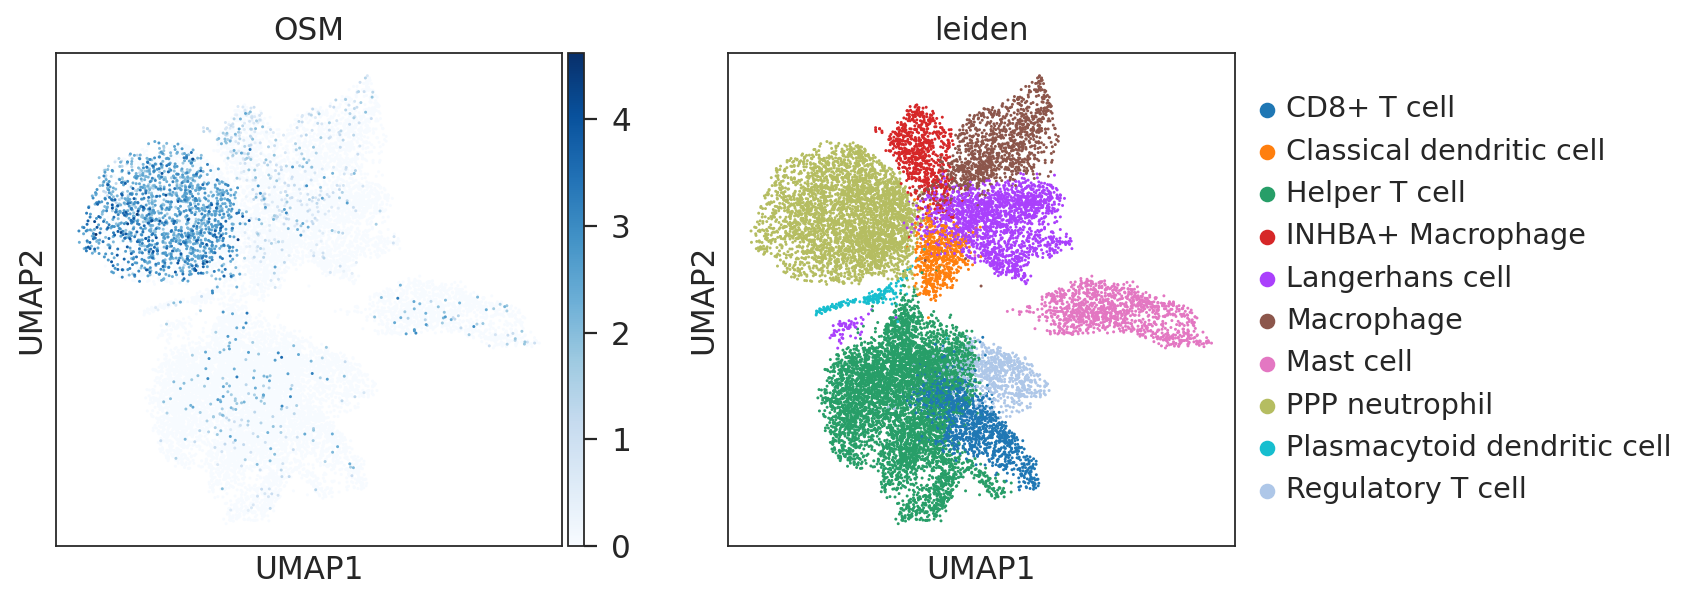

In [18]:
sc.pl.umap(adata_merge[adata_merge.obs.sample_type =='IMMU'], color=['OSM', 'leiden'], cmap='Blues')

In [19]:
adata_merge.obs['leiden'].cat.categories

Index(['Basal_Control_KC', 'Basal_Lesion_KC', 'CD8+ T cell',
       'Classical dendritic cell', 'Eccrine gland cell', 'Helper T cell',
       'INHBA+ Macrophage', 'Langerhans cell', 'Lymphatic endothelial cell',
       'Macrophage', 'Mast cell', 'Neuron', 'PPP neutrophil',
       'Plasmacytoid dendritic cell', 'Pro inflammatory fibroblast',
       'Regulatory T cell', 'Secretory papillary fibroblast',
       'Secretory reticular fibroblast', 'Suprabasal_Control_KC',
       'Suprabasal_Lesion_KC', 'Vascular endothelial cell 1',
       'Vascular endothelial cell 2', 'Vascular smooth muscle cell'],
      dtype='object')

In [20]:
from cellphonedb.utils import search_utils

immu_cell_type = ['CD8+ T cell', 'Classical dendritic cell', 'INHBA+ Macrophage',
       'Langerhans cell', 'Macrophage', 'Mast cell', 'PPP neutrophil',
       'Plasmacytoid dendritic cell', 'Regulatory T cell', 'Helper T cell',
       ]
kc_cell_type = ['Basal_Control_KC', 'Basal_Lesion_KC', 'Suprabasal_Control_KC', 'Suprabasal_Lesion_KC'] 

search_results = search_utils.search_analysis_results(
    query_cell_types_1 = immu_cell_type,  # List of cells 1, will be paired to cells 2 (list or 'All').
    query_cell_types_2 = kc_cell_type,     # List of cells 2, will be paired to cells 1 (list or 'All').
    # query_genes = [''],                                       # filter interactions based on the genes participating (list).
    # query_interactions = ['CSF1_CSF1R'],                            # filter intereactions based on their name (list).
    significant_means = cpdb_results['significant_means'],          # significant_means file generated by CellphoneDB.
    deconvoluted = cpdb_results['deconvoluted'],                    # devonvoluted file generated by CellphoneDB.
    interaction_scores = cpdb_results['interaction_scores'],        # interaction score generated by CellphoneDB.
    query_minimum_score = 50,                                       # minimum score that an interaction must have to be filtered.
    separator = '|',                                                # separator (default: |) employed to split cells (cellA|cellB).
    long_format = True,                                             # converts the output into a wide table, removing non-significant interactions
    # query_classifications = ['Signaling by Transforming growth factor']
)

search_results

,interacting_pair,partner_a,partner_b,gene_a,gene_b,directionality,classification,interacting_cells,significant_mean
6,C10orf99_GPR15,simple:Q6UWK7,simple:P49685,C10orf99,GPR15,Ligand-Receptor,NaN,Basal_Control_KC|CD8+ T cell,0.12080
21,CDH1_KLRG1,simple:P12830,simple:Q96E93,CDH1,KLRG1,Ligand-Receptor,Adhesion by Cadherin,Basal_Control_KC|CD8+ T cell,0.20372
30,CDH1_integrin_aEb7_complex,simple:P12830,complex:integrin_aEb7_complex,CDH1,NaN,Adhesion-Adhesion,Adhesion by Cadherin,Basal_Control_KC|CD8+ T cell,0.22251
39,Cholesterol_byDHCR24_RORA,complex:Cholesterol_byDHCR24,simple:P35398,NaN,RORA,Ligand-Receptor,Signaling by Cholesterol/Desmosterol,Basal_Control_KC|CD8+ T cell,0.60955
57,Cholesterol_byLIPA_RORA,complex:Cholesterol_byLIPA,simple:P35398,NaN,RORA,Ligand-Receptor,Signaling by Cholesterol,Basal_Control_KC|CD8+ T cell,0.54475
...,...,...,...,...,...,...,...,...,...
5350,Cholesterol_byLIPA_RORA,complex:Cholesterol_byLIPA,simple:P35398,NaN,RORA,Ligand-Receptor,Signaling by Cholesterol,Suprabasal_Lesion_KC|Regulatory T cell,0.77730
5353,CXCL14_CXCR4,simple:O95715,simple:P61073,CXCL14,CXCR4,Ligand-Receptor,Signaling by Chemokines,Suprabasal_Lesion_KC|Regulatory T cell,1.46603
5354,ProstaglandinE2_byPTGES2_PTGER4,complex:ProstaglandinE2_byPTGES2,simple:P35408,NaN,PTGER4,Ligand-Receptor,Signaling by Prostaglandin,Suprabasal_Lesion_KC|Regulatory T cell,0.29288
5355,PPIA_BSG,simple:P62937,simple:P35613,PPIA,BSG,Ligand-Receptor,NaN,Suprabasal_Lesion_KC|Regulatory T cell,1.44232


In [21]:
sns.set_theme(style="white")

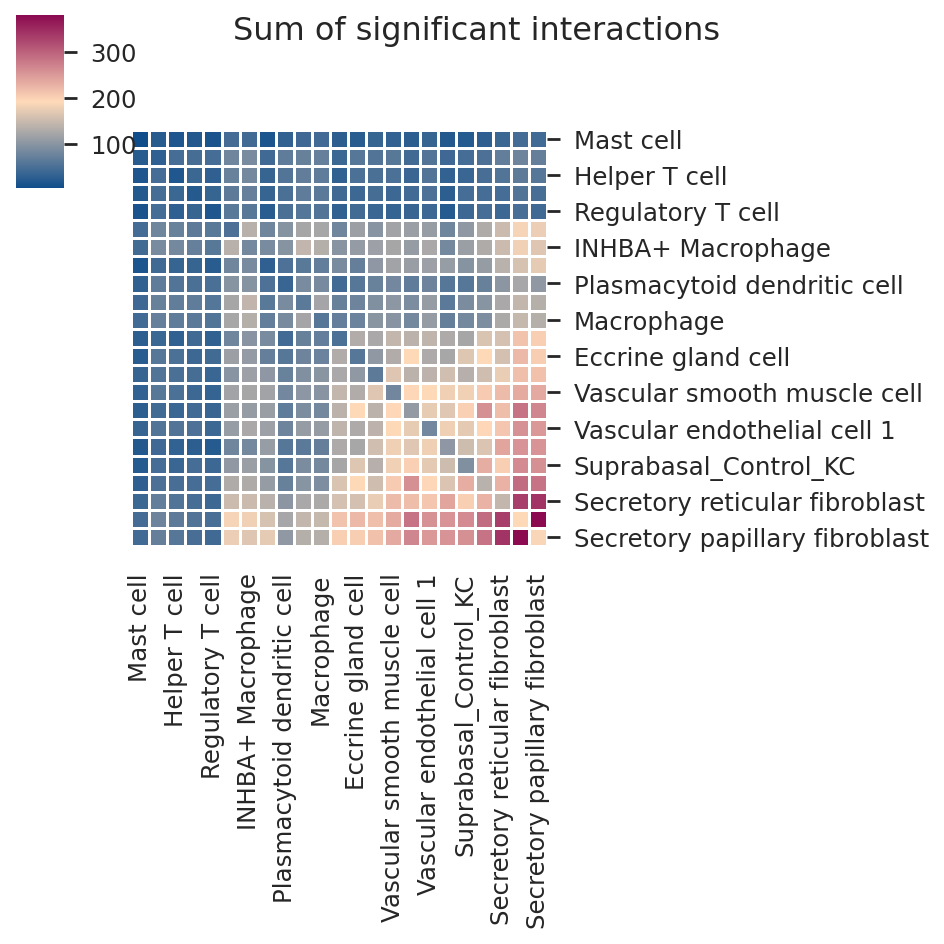

In [22]:
matrix_plot = kpy.plot_cpdb_heatmap(pvals = cpdb_results['pvalues'],
                      degs_analysis = False,
                      figsize = (6, 6),
                      title = "Sum of significant interactions")

plt.savefig('figures/fig4_3/matrix_sum_of_immu_significant_interactions.pdf')

In [23]:
# "CXCL1::ACKR1","CXCL1::CXCR1","CXCL1::CXCR2","CXCL2::CXCR1","CXCL2::CXCR2","CXCL2::XCR1","CXCL3::CXCR1","CXCL3::CXCR2","CXCL5::CXCR2","CXCL8::ACKR1","CXCL8::CXCR1","CXCL8::CXCR2","CXCL8::SDC1","CXCL8::SDC2","IL1B::IL1R1","IL1B::IL1R2", "IL1B::IL1RAP","CCL20::ACKR4","CCL20::CCR6", "CCL20::CXCR3","IL19::IL20RA","IL19::IL20RB",'IL17A::IL17RA','IL17A::IL17RC','IL17B::IL17RB','IL17C::IL17RA','IL17C::IL17RE','IL17F::IL17RA','IL22::IL10RA','IL22::IL10RB','IL22::IL22RA1','IL22::IL22RA2','IL23A::IL12RB1','IL23A::IL23R',"IL6::IL6R","IL6::IL6ST"

In [24]:
cpdb_results['means'][cpdb_results['means']['id_cp_interaction']=='CPI-SS08376F0E6']

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,...,Vascular smooth muscle cell|Plasmacytoid dendritic cell,Vascular smooth muscle cell|Pro inflammatory fibroblast,Vascular smooth muscle cell|Regulatory T cell,Vascular smooth muscle cell|Secretory papillary fibroblast,Vascular smooth muscle cell|Secretory reticular fibroblast,Vascular smooth muscle cell|Suprabasal_Control_KC,Vascular smooth muscle cell|Suprabasal_Lesion_KC,Vascular smooth muscle cell|Vascular endothelial cell 1,Vascular smooth muscle cell|Vascular endothelial cell 2,Vascular smooth muscle cell|Vascular smooth muscle cell
826,CPI-SS08376F0E6,CSF3_CSF3R,simple:P09919,simple:Q99062,CSF3,CSF3R,True,False,True,curated,...,0.04764,0.00685,0.01278,0.00203,0.00278,0.00032,0.01162,0.00426,0.00423,0.00198


In [25]:
# reload kpy
import importlib
kpy = importlib.reload(kpy)

In [42]:
dot_plot_il6 = kpy.plot_cpdb(
        adata = adata_merge,
        keep_significant_only=False,
        cell_type1 = '|'.join(immu_cell_type),
        cell_type2 = '|'.join(kc_cell_type),
        means = cpdb_results['means'],
        pvals = cpdb_results['pvalues'],
        celltype_key = "leiden",
        genes = ['IL6', 'IL11', 'IL27', 'IL31', 'OSM', 'CNTF', 'LIF', 'CT-1', 'CLCF1', 'NPN'],
        figsize = (14, 7),
        title = "Interactions between Immune and Keratinocyte cells of IL6 family cytokines",
        max_size = 5,
        highlight_size = 2,
        degs_analysis = False,
        standard_scale = True,
        # interaction_scores = cpdb_results['interaction_scores'],
        result_precision = 5,
        scale_alpha_by_interaction_scores = True,
        return_table=True
    )

In [43]:
dot_plot_il6.pvals.min()

1e-05

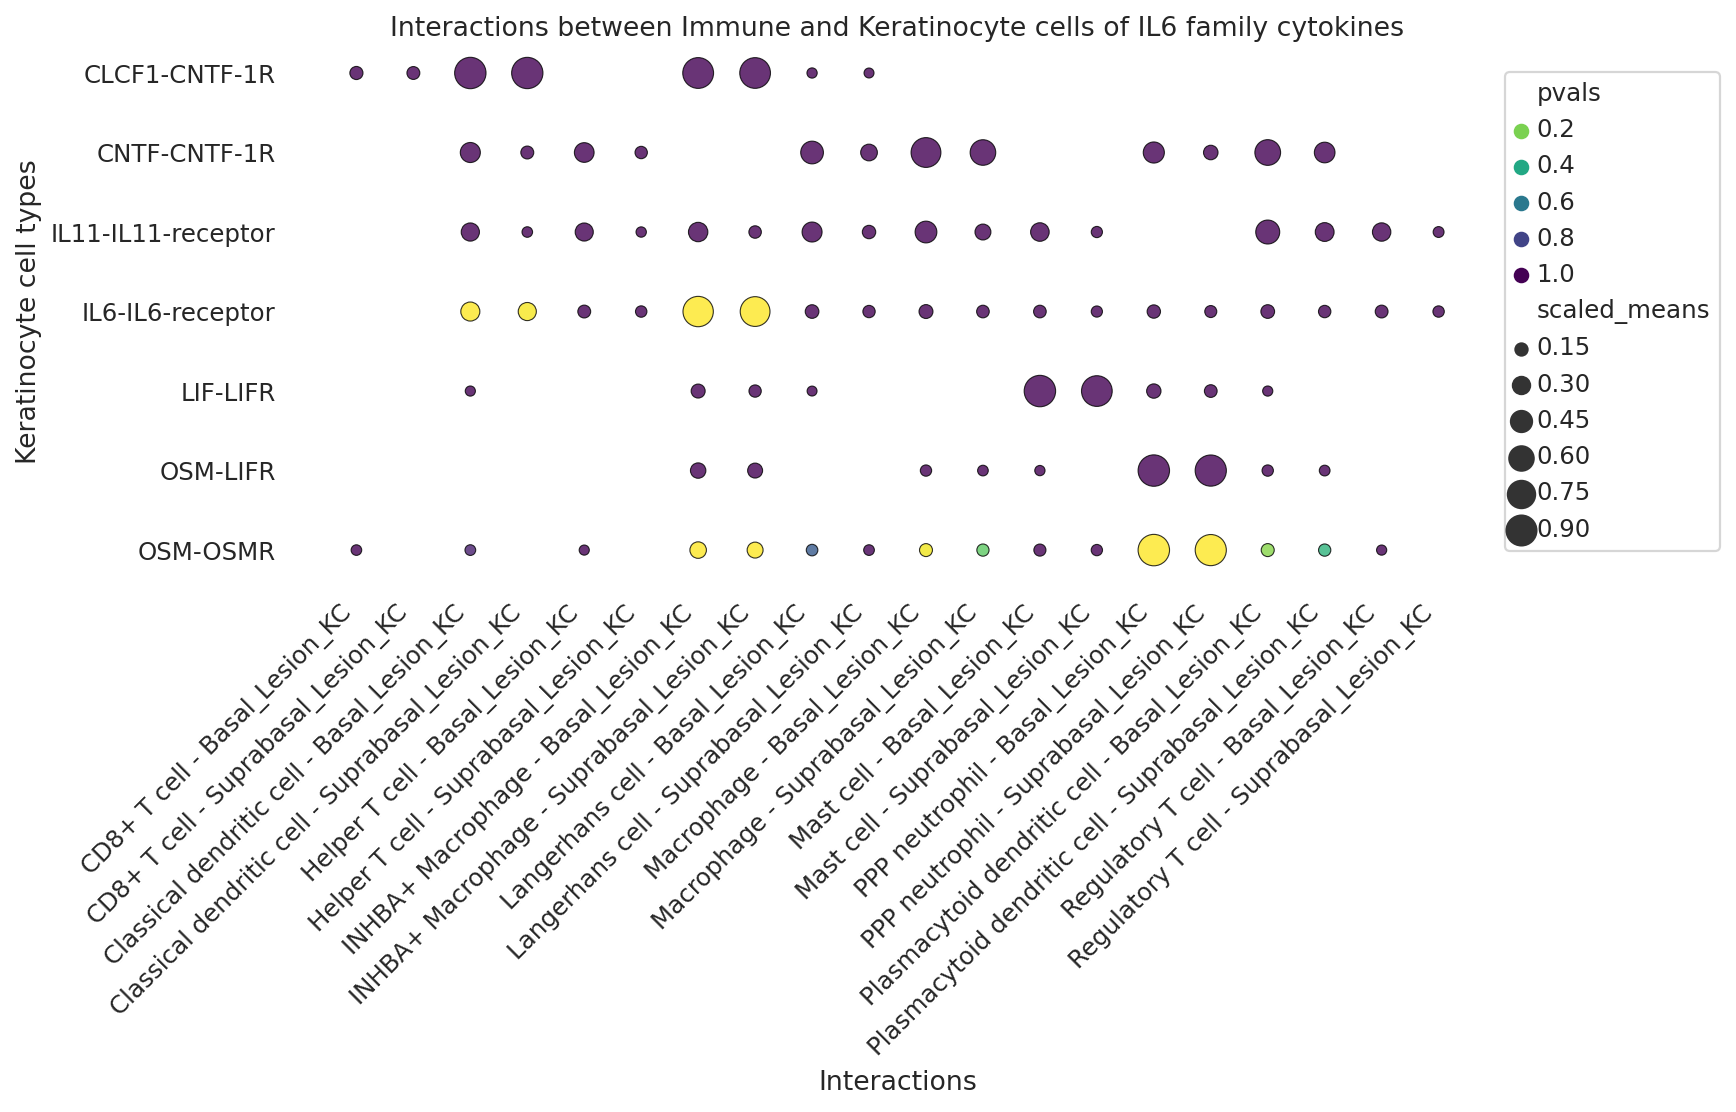

In [45]:
dot_plot_il6
dot_plot_il6.loc[:, 'Pairs'] = dot_plot_il6.interaction_group.str.split('<').str[-1].astype('category')
dot_plot_il6.loc[:,'From'] = dot_plot_il6.celltype_group.str.split('-').str[0]
dot_plot_il6.loc[:,'To'] = dot_plot_il6.celltype_group.str.split('-').str[1]
dot_plot_il6.loc[:,'Interaction'] = dot_plot_il6.From + ' - ' + dot_plot_il6.To

dot_plot_il6 = dot_plot_il6[dot_plot_il6['To'].str.contains('Lesion_KC')]
dot_plot_il6 = dot_plot_il6[~dot_plot_il6.Pairs.str.contains('CD')] # remove surface markers
dot_plot_il6 = dot_plot_il6[dot_plot_il6.scaled_means > 0.1]
dot_plot_il6.loc[:,'Interaction'] = dot_plot_il6.loc[:,'Interaction'].astype('category')

with rc_context({'figure.figsize': (12, 8)}):
    g = sns.scatterplot(data=dot_plot_il6, y='Pairs', x='Interaction', size='scaled_means', hue='pvals', sizes=(20, 200), palette='viridis_r', alpha=0.8,
                        edgecolor='black', linewidth=0.5, legend='brief')
    g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
    g.set_title('Interactions between Immune and Keratinocyte cells of IL6 family cytokines')
    g.set_xlabel('Interactions')
    g.set_ylabel('Keratinocyte cell types')
    g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    sns.despine(bottom=True, left=True)
    plt.subplots_adjust(right=0.8, bottom=0.5)
    plt.savefig('figures/fig4_3/IL6_family_cytokines_interactions.pdf')

In [29]:
immu_cell_type = ['CD8+ T cell', 'Classical dendritic cell', 'INHBA+ Macrophage',
         'Langerhans cell', 'Macrophage', 'Mast cell', 'PPP neutrophil',
         'Plasmacytoid dendritic cell', 'Regulatory T cell', 'Helper T cell',
         ]

dot_plot = kpy.plot_cpdb(
        adata = adata_merge,
        keep_significant_only=False,
        cell_type1 = '|'.join(immu_cell_type),
        cell_type2 = '|'.join(kc_cell_type),
        means = cpdb_results['means'],
        pvals = cpdb_results['pvalues'],
        celltype_key = "leiden",
        genes = ["OSMR"],
        figsize = (14, 7),
        title = "Interactions between Immune and Keratinocyte cells of IL6 family cytokines",
        max_size = 8,
        highlight_size = 2,
        degs_analysis = False,
        standard_scale = True,
        # interaction_scores = cpdb_results['interaction_scores'],
        scale_alpha_by_interaction_scores = True,
        return_table=True
    )

In [30]:
dot_plot.loc[:,'From'] = dot_plot.celltype_group.str.split('-').str[0]
dot_plot.loc[:,'To'] = dot_plot.celltype_group.str.split('-').str[1]
dot_plot.columns

Index(['interaction_group', 'celltype_group', 'scaled_means', 'pvals',
       'x_means', 'y_means', 'x_stroke', 'neglog10p', 'significant',
       'is_integrin', 'directionality', 'classification', 'From', 'To'],
      dtype='object')

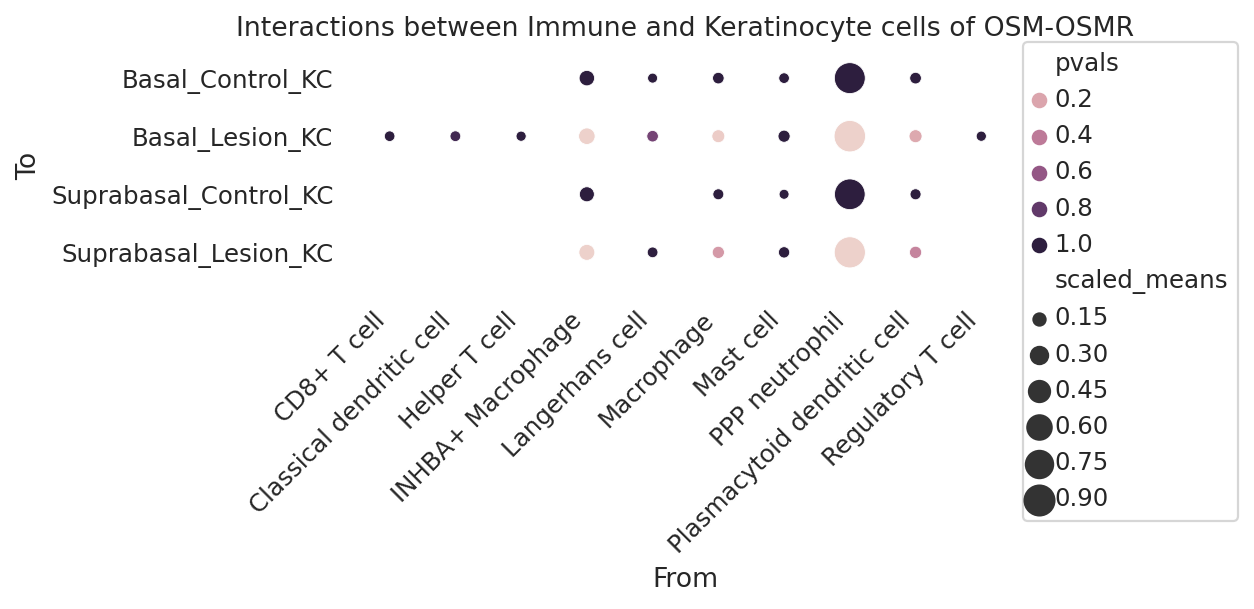

In [36]:
with rc_context({'figure.figsize': (8, 4)}):
    dot_plot_select = dot_plot[dot_plot.scaled_means > 0.1][dot_plot.To.str.contains('KC')]
    dot_plot_select['To'] = dot_plot_select['To'].astype('category')
    dot_plot_select['From'] = dot_plot_select['From'].astype('category')
    dot_plot_select.To.cat.reorder_categories(kc_cell_type[::-1], inplace=True)
    
    g = sns.scatterplot(data=dot_plot_select, x='From', y='To', size='scaled_means', hue='pvals', sizes=(20, 200), alpha=1)
    g.legend(loc='center left', bbox_to_anchor=(1, 0), ncol=1)
    g.set_title('Interactions between Immune and Keratinocyte cells of OSM-OSMR')
    g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
    g.set_ylim(-0.5, 3.5)
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.savefig('figures/fig4_3/OSM_OSMR_interactions.pdf')